In [ ]:
#

# File setup

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pyproj
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import rioxarray as rxr
from shapely.ops import transform
import shapely
import scipy as sp
import json

In [2]:
# Transformer for changing cartesian lat long in deg to 	New Zealand Transverse Mercator 2000
# transformer = \
#     pyproj.Transformer.from_crs(pyproj.CRS("epsg:4326"),pyproj.CRS("NZTM2000"))
transformer = \
    pyproj.Transformer.from_crs(pyproj.CRS("EPSG:32760"),pyproj.CRS("EPSG:4326")) 

# Earthquakes

## Load the Earthquake Data

In [3]:
# Load the data using geopandas

folder_loc = r'a_earthquake/'

gdf_quake = gpd.read_file('{}lognormal_params_pga.shp'.format(folder_loc))

# # convert the geopandas to pandas
gdf_quake


,lon,lat,meanpga_lo,sigmapga_l,mean_OQ,meanlognor,geometry
0,176.85822,-39.58472,-0.858988,0.720130,0.548499,0.527331,POINT (176.85822 -39.58472)
1,176.86022,-39.58472,-0.857252,0.714725,0.549525,0.527331,POINT (176.86022 -39.58472)
2,176.86222,-39.58472,-0.898152,0.738619,0.533949,0.527331,POINT (176.86222 -39.58472)
3,176.86422,-39.58472,-0.840356,0.738452,0.566510,0.527331,POINT (176.86422 -39.58472)
4,176.86622,-39.58472,-0.851964,0.727102,0.555765,0.527331,POINT (176.86622 -39.58472)
...,...,...,...,...,...,...,...
6734,176.92422,-39.40272,-0.962404,0.739941,0.504132,0.527331,POINT (176.92422 -39.40272)
6735,176.92622,-39.40272,-0.929842,0.740930,0.517267,0.527331,POINT (176.92622 -39.40272)
6736,176.92822,-39.40272,-0.949768,0.737113,0.507194,0.527331,POINT (176.92822 -39.40272)
6737,176.93022,-39.40272,-0.923478,0.738005,0.520892,0.527331,POINT (176.93022 -39.40272)


## Create prob distributions from mu and sigma of earthquake data

In [4]:
lat_lon_percentile = {}
for i in np.arange(0,len(gdf_quake),1):
    mu,sigma = gdf_quake.meanpga_lo[i],gdf_quake.sigmapga_l[i]
    percentile_dict = {}
    for percentile in np.arange(0,110,10):
        percentile_dict.update({
            str(percentile/100):np.percentile(np.random.normal(mu, sigma, 100000),percentile)
        })
    lat_lon_percentile.update({
        tuple(gdf_quake.loc[i,['lon','lat']]):percentile_dict
    })


In [5]:
df_quake_binned = pd.DataFrame.from_dict(lat_lon_percentile,orient='index')
df_quake_binned = df_quake_binned.reset_index().rename(columns={'level_0':'lon','level_1':'lat'})

In [6]:
cols = ['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0']
bin_max = np.max(np.max(df_quake_binned[cols]))
bin_min = np.min(np.min(df_quake_binned[cols]))
bin_num = 3 # plus zero
bin_edges = np.arange(bin_min,bin_max,(bin_max-bin_min)/4)
binned_quake_dict = {}
for i in np.arange(0,len(df_quake_binned),1):
    df_test = pd.DataFrame(df_quake_binned.loc[i,cols])
    prob_bin_1 = np.interp(bin_edges[1],df_test[i],df_test.index.astype(float))
    prob_bin_2 = np.interp(bin_edges[2],df_test[i],df_test.index.astype(float))-prob_bin_1
    prob_bin_3 = 1-prob_bin_2-prob_bin_1
    binned_quake_dict.update({
        tuple(df_quake_binned.loc[i,['lat','lon']]):
        {
            'low_shaking_prob':prob_bin_1,
            'med_shaking_prob':prob_bin_2,
            'high_shaking_prob':prob_bin_3
        }
    })

In [7]:
# Save definition of earthquake bins
earthquake_bins = bin_edges

In [8]:
df_quake_binned = pd.DataFrame.from_dict(binned_quake_dict).T

In [9]:
df_quake_binned = df_quake_binned.reset_index().rename(columns={'level_0':'lat','level_1':'lon'})
df_quake_binned

,lat,lon,low_shaking_prob,med_shaking_prob,high_shaking_prob
0,-39.58472,176.85822,0.027745,0.403914,0.568341
1,-39.58472,176.86022,0.026065,0.407266,0.566669
2,-39.58472,176.86222,0.036007,0.421274,0.542719
3,-39.58472,176.86422,0.037948,0.387467,0.574585
4,-39.58472,176.86622,0.028206,0.402556,0.569238
...,...,...,...,...,...
6734,-39.40272,176.92422,0.036103,0.454159,0.509738
6735,-39.40272,176.92622,0.037729,0.435858,0.526413
6736,-39.40272,176.92822,0.036403,0.444725,0.518872
6737,-39.40272,176.93022,0.036313,0.434307,0.529380


## Visualise spatial variation in shaking

<AxesSubplot:>

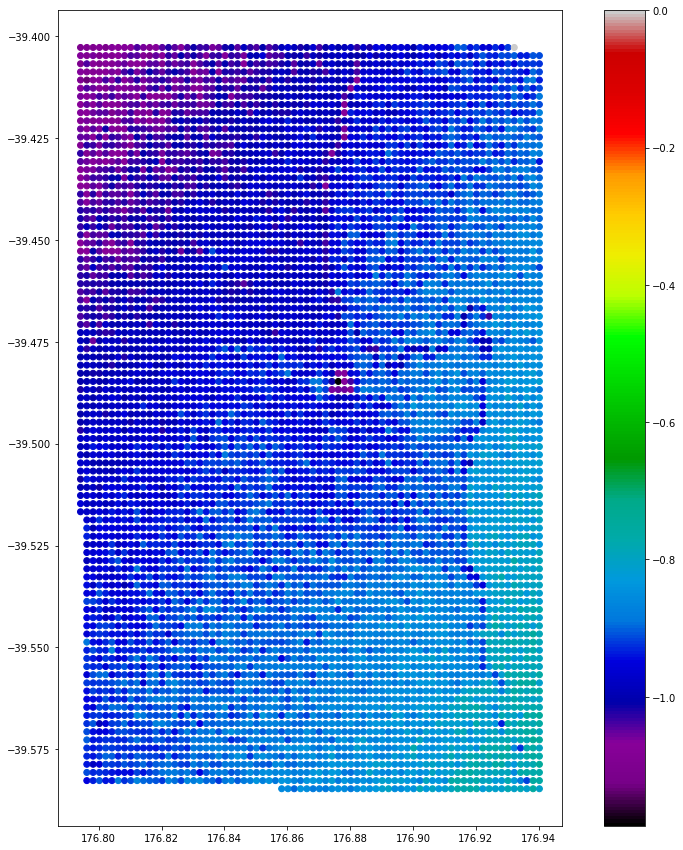

In [10]:
fig = plt.figure(figsize=(15,15))

ax1 = plt.subplot2grid((1,1),(0,0))

gdf_quake.plot(column='meanpga_lo',legend=True,ax=ax1,cmap='nipy_spectral')

# ax1.set_xlim(172.8,173.2)
# ax1.set_ylim(1.3,1.68)

# Liquefaction

## Load liquefaction data

In [11]:
# Load the data using geopandas

folder_loc = r'c_liquefaction/'

gdf_liq = gpd.read_file('{}liq_areas_HB.shp'.format(folder_loc))

# # convert the geopandas to pandas
df_liq  = pd.DataFrame(gdf_liq)


In [12]:
pd.read_csv('{}totmeans_LSN.csv'.format(folder_loc))

,zones,Mag,0,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1
0,A,5,0.0,1.088235,6.705882,13.982353,19.964706,22.670588,24.164706,25.176471,25.858824,26.370588,26.764706,27.088235
1,B,5,0.0,0.710667,4.610667,10.394000,16.071333,18.186667,19.216000,19.850667,20.294667,20.628667,20.882667,21.088667
2,C,5,0.0,1.357143,8.621429,17.585714,23.432143,24.617857,25.110714,25.417857,25.596429,25.725000,25.814286,25.892857
3,D,5,0.0,1.748837,10.748837,21.958140,26.546512,27.323256,27.620930,27.788372,27.916279,28.002326,28.067442,28.127907
4,E,5,0.0,0.170588,1.058824,3.335294,6.182353,7.082353,7.635294,8.005882,8.258824,8.435294,8.558824,8.641176
5,F,5,0.0,0.200000,1.589474,5.268421,13.173684,17.521053,19.426316,20.436842,21.084211,21.547368,21.931579,22.215789
6,M,5,0.0,0.285526,2.109211,6.810526,14.776316,18.315789,19.856579,20.678947,21.172368,21.521053,21.767105,21.957895
7,N,5,0.0,0.120455,0.987879,3.345455,7.787879,9.840152,10.864394,11.528788,12.006818,12.382576,12.681061,12.934848
8,O,5,0.0,0.100000,0.721875,1.962500,3.637500,4.425000,4.806250,5.028125,5.150000,5.225000,5.284375,5.315625
9,P,5,0.0,0.383871,2.529032,6.645161,11.622581,14.180645,15.393548,16.103226,16.545161,16.841935,17.045161,17.212903


## Create Probability Distribution per zone, per magnitude

In [13]:
cols = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
df_liq_binned = pd.read_csv('{}totmeans_LSN.csv'.format(folder_loc))
bin_max = np.max(np.max(df_liq_binned[cols]))
bin_min = np.min(np.min(df_liq_binned[cols]))
bin_num = 3 # plus zero
bin_edges = np.arange(0,bin_max,(bin_max-0)/4)
binned_liq_dict = {}
for i in np.arange(0,len(df_liq_binned),1):
    df_test = pd.DataFrame(df_liq_binned.loc[i,cols])
    prob_bin_1 = np.interp(bin_edges[1],df_test[i],df_test.index.astype(float)) #don't start with zero because it's obvs zero
    prob_bin_2 = np.interp(bin_edges[2],df_test[i],df_test.index.astype(float))-prob_bin_1
    prob_bin_3 = 1-prob_bin_2-prob_bin_1
    binned_liq_dict.update({
        tuple(df_liq_binned.loc[i,['zones','Mag']]):
        {
            'zero_liq':0,
            'low_liq':prob_bin_1,
            'med_liq':prob_bin_2,
            'high_liq':prob_bin_3
        }
    })

In [14]:
# Save definition of liquefaction bins
liquefaction_bins = bin_edges

In [15]:
df_liq_binned = pd.DataFrame(binned_liq_dict).T
df_liq_binned = df_liq_binned.reset_index(drop=False).rename(columns={'level_1':'Mag','level_0':'Liq_Class'})
df_liq_binned = df_liq_binned[df_liq_binned.Mag==5].drop('Mag',axis=1)
df_liq_binned.set_index('Liq_Class',inplace=True)
liq_bin_dict = df_liq_binned.T.to_dict()
liq_bin_dict

{'A': {'zero_liq': 0.0,
  'low_liq': 0.14877965328467152,
  'med_liq': 0.0641505335393206,
  'high_liq': 0.7870698131760079},
 'B': {'zero_liq': 0.0,
  'low_liq': 0.16885309304444668,
  'med_liq': 0.10797668066870225,
  'high_liq': 0.7231702262868511},
 'C': {'zero_liq': 0.0,
  'low_liq': 0.1370999896437448,
  'med_liq': 0.04546266570008284,
  'high_liq': 0.8174373446561723},
 'D': {'zero_liq': 0.0,
  'low_liq': 0.12785402423339878,
  'med_liq': 0.036507649089555255,
  'high_liq': 0.835638326677046},
 'E': {'zero_liq': 0.0,
  'low_liq': 0.4534574468085106,
  'med_liq': 0.5465425531914894,
  'high_liq': 5.551115123125783e-17},
 'F': {'zero_liq': 0.0,
  'low_liq': 0.22668500822432835,
  'med_liq': 0.10970938003945174,
  'high_liq': 0.6636056117362199},
 'M': {'zero_liq': 0.0,
  'low_liq': 0.20712314658271636,
  'med_liq': 0.09262033852192997,
  'high_liq': 0.7002565148953537},
 'N': {'zero_liq': 0.0,
  'low_liq': 0.2907722092929941,
  'med_liq': 0.7092277907070059,
  'high_liq': 0.0},
 '

In [16]:
liq_bin_dict['No'] = {'zero_liq':1.0,'low_liq':0,'med_liq':0,'high_liq':0}

#### There are categories that I don't have prob distrubtions for
#### Make them all zero for now?
liq_bin_dict['H'] = {'zero_liq':1.0,'low_liq':0,'med_liq':0,'high_liq':0}
liq_bin_dict['Esk'] = {'zero_liq':1.0,'low_liq':0,'med_liq':0,'high_liq':0}
liq_bin_dict['Z'] = {'zero_liq':1.0,'low_liq':0,'med_liq':0,'high_liq':0}

liq_bin_dict

{'A': {'zero_liq': 0.0,
  'low_liq': 0.14877965328467152,
  'med_liq': 0.0641505335393206,
  'high_liq': 0.7870698131760079},
 'B': {'zero_liq': 0.0,
  'low_liq': 0.16885309304444668,
  'med_liq': 0.10797668066870225,
  'high_liq': 0.7231702262868511},
 'C': {'zero_liq': 0.0,
  'low_liq': 0.1370999896437448,
  'med_liq': 0.04546266570008284,
  'high_liq': 0.8174373446561723},
 'D': {'zero_liq': 0.0,
  'low_liq': 0.12785402423339878,
  'med_liq': 0.036507649089555255,
  'high_liq': 0.835638326677046},
 'E': {'zero_liq': 0.0,
  'low_liq': 0.4534574468085106,
  'med_liq': 0.5465425531914894,
  'high_liq': 5.551115123125783e-17},
 'F': {'zero_liq': 0.0,
  'low_liq': 0.22668500822432835,
  'med_liq': 0.10970938003945174,
  'high_liq': 0.6636056117362199},
 'M': {'zero_liq': 0.0,
  'low_liq': 0.20712314658271636,
  'med_liq': 0.09262033852192997,
  'high_liq': 0.7002565148953537},
 'N': {'zero_liq': 0.0,
  'low_liq': 0.2907722092929941,
  'med_liq': 0.7092277907070059,
  'high_liq': 0.0},
 '

## Convert Liquefaction to lat-lon (not zone)

In [17]:
# New method for interpolation
transformer = \
        pyproj.Transformer.from_crs(pyproj.CRS("epsg:2193"),pyproj.CRS("epsg:4326"))

df_liq['new_geometry'] = [transform(transformer.transform,
                 df_liq.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))[x]) for x in \
                np.arange(0,len(df_liq),1)]

new_liq_dict = {}

for index,row in df_quake_binned.iterrows():
    # transform the point to shape
    point = Point(row.lat,row.lon)
    
    lclass = [lclass for shape,lclass in zip(df_liq['new_geometry'],df_liq.Liq_Class) if shape.contains(point)]
    if len(lclass)==0:
        lclass = 'No'
    else:
        lclass = lclass[0]
        
    row['Liq_Class'] = lclass
    
    new_liq_dict.update({
        index:row
    })



In [18]:
df_quake = pd.DataFrame.from_dict(new_liq_dict,orient='index')
np.unique(df_quake.Liq_Class)

array(['A', 'B', 'C', 'D', 'E', 'Esk', 'F', 'H', 'M', 'No', 'Z'],
      dtype=object)

In [19]:
df_quake = df_quake.join(pd.DataFrame.from_dict({index:liq_bin_dict[row.Liq_Class] for index,row in df_quake.iterrows()},orient='index'))


In [20]:
df_quake

,lat,lon,low_shaking_prob,med_shaking_prob,high_shaking_prob,Liq_Class,zero_liq,low_liq,med_liq,high_liq
0,-39.58472,176.85822,0.027745,0.403914,0.568341,No,1.0,0.0,0.0,0.0
1,-39.58472,176.86022,0.026065,0.407266,0.566669,No,1.0,0.0,0.0,0.0
2,-39.58472,176.86222,0.036007,0.421274,0.542719,No,1.0,0.0,0.0,0.0
3,-39.58472,176.86422,0.037948,0.387467,0.574585,No,1.0,0.0,0.0,0.0
4,-39.58472,176.86622,0.028206,0.402556,0.569238,No,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6734,-39.40272,176.92422,0.036103,0.454159,0.509738,No,1.0,0.0,0.0,0.0
6735,-39.40272,176.92622,0.037729,0.435858,0.526413,No,1.0,0.0,0.0,0.0
6736,-39.40272,176.92822,0.036403,0.444725,0.518872,No,1.0,0.0,0.0,0.0
6737,-39.40272,176.93022,0.036313,0.434307,0.529380,No,1.0,0.0,0.0,0.0


In [21]:
# ## Get the liquefaction by lat-lon

# new_liq_dict = {}
# print(len(df_quake))
# # For a single quake, loop over each area and get combined hazard at each point
# for index,row in df_quake.iterrows():
#     # transform the point to shape
#     point = Point(row.lat,row.lon)

#     transformer = \
#         pyproj.Transformer.from_crs(pyproj.CRS("epsg:2193"),pyproj.CRS("epsg:4326"))

#     geometry = [transform(transformer.transform,
#                  df_liq.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))[x]) for x in \
#                 np.arange(0,len(df_liq),1)]
    
#     row['geometry'] = geometry
    
# #     # Add liquefaction
# #     df_liq['point_in_poly'] = [x.contains(point) for x in geometry]
# #     df_liq_at_point = df_liq[df_liq['point_in_poly']==True]
# #     if not df_liq_at_point.empty:
# #         row['Liq_Class'] = df_liq_at_point.reset_index(drop=True).loc[0,'Liq_Class']
# #     else:
# #         row['Liq_Class'] = 'None'
# #     print(index)
    
#     # Add to dictionary
#     new_liq_dict.update({
#         index:row
#     })
#     print(index)

In [22]:
# df_liq_new = pd.DataFrame.from_dict(new_liq_dict,orient='index')
# df_liq_new_not_nan = df_liq_new.dropna()

In [23]:
# df_liq['geometry_transormed'] = geometry

In [24]:
# df_liq_new = pd.DataFrame.from_dict(new_liq_dict,orient='index')
# df_liq_new_not_nan = df_liq_new.dropna()
# # [liq_bin_dict[lclass]['low'] for lclass in df_liq_new_not_nan.Liq_Class]

# ##### I'm not sure what's gone on here

In [25]:
# import descartes

# ax = plt.subplot2grid((1,1),(0,0))

# ax.scatter(df_quake.lat[2000],df_quake.lon[2000],alpha=1,c='r',zorder=1000)

# [ax.add_patch(descartes.PolygonPatch(x,alpha=1)) for x in geometry]

# # ax.scatter(descartes.PolygonPatch(point,alpha=1),zorder=10000,c='r')
# plt.show()

In [26]:
# df_liq_new = pd.DataFrame.from_dict(new_liq_dict,orient='index').drop('meanpga_lo',axis=1)
# df_liq_new

## Visualise Liquefaction class

In [27]:
# fig = plt.figure(figsize=(15,15))

# ax1 = plt.subplot2grid((1,1),(0,0))

# gdf_liq.plot(column='Liq_Class',legend=True,ax=ax1,cmap='nipy_spectral')

# test_point = transformer.transform(-39.486337,176.911780) 

# plt.scatter(test_point[1],test_point[0],c='k',marker='*',s=100)

# # ax1.set_xlim(172.8,173.2)
# # ax1.set_ylim(1.3,1.68)

# Tsunami

## Load Tsunami data

In [28]:

file = r'b_tsunami/max_H.tif'

from PIL import Image
im = Image.open(file)
imarray = np.array(im)
imarray[imarray>100000] = np.nan

In [29]:
pre_lidar_dem = rxr.open_rasterio(file,
                                 masked=True)

x = np.array(pre_lidar_dem.x)
y = np.array(pre_lidar_dem.y)

In [30]:
df_tsunami = pd.DataFrame(imarray)
df_tsunami.columns = x
df_tsunami.index = y
df_tsunami.reset_index(drop=False,inplace=True)
df_tsunami = df_tsunami.melt(id_vars='index')
df_tsunami.columns = ['lat','lon','tsu_height']
df_tsunami.dropna(inplace=True)
df_tsunami.reset_index(drop=True,inplace=True)
transformer = \
    pyproj.Transformer.from_crs(pyproj.CRS("epsg:2193"),pyproj.CRS("epsg:4326"))
df_tsunami[('lat,lon')] = [transformer.transform(y,x) for x,y in zip(df_tsunami.lon,df_tsunami.lat)]
df_tsunami['lon'] = [x[1] for x in df_tsunami[('lat,lon')]]
df_tsunami['lat'] = [x[0] for x in df_tsunami[('lat,lon')]]
df_tsunami

,lat,lon,tsu_height,"lat,lon"
0,-39.658310,176.810359,0.0,"(-39.65830988932666, 176.81035940292963)"
1,-39.658445,176.810367,0.0,"(-39.65844474488139, 176.81036681903365)"
2,-39.658580,176.810374,0.0,"(-39.65857960043183, 176.8103742351875)"
3,-39.658714,176.810382,0.0,"(-39.65871445597795, 176.81038165139125)"
4,-39.658849,176.810389,0.0,"(-39.65884931151979, 176.81038906764488)"
...,...,...,...,...
5245969,-39.658517,177.199429,0.0,"(-39.65851679747624, 177.19942940037217)"
5245970,-39.658652,177.199438,0.0,"(-39.658651588775534, 177.199437572499)"
5245971,-39.658786,177.199446,0.0,"(-39.65878638007029, 177.19944574468073)"
5245972,-39.658921,177.199454,0.0,"(-39.65892117136049, 177.19945391691743)"


In [31]:
p33 = np.percentile(df_tsunami.tsu_height,33)
p67 = np.percentile(df_tsunami.tsu_height,67)

df_tsunami.loc[df_tsunami.tsu_height<p33,'low'] = 1
df_tsunami.loc[(df_tsunami.tsu_height>p33)&(df_tsunami.tsu_height<p67),'med'] = 1
df_tsunami.loc[df_tsunami.tsu_height>p67,'high'] = 1
df_tsunami.fillna(0,inplace=True)
df_tsunami

,lat,lon,tsu_height,"lat,lon",low,med,high
0,-39.658310,176.810359,0.0,"(-39.65830988932666, 176.81035940292963)",1.0,0.0,0.0
1,-39.658445,176.810367,0.0,"(-39.65844474488139, 176.81036681903365)",1.0,0.0,0.0
2,-39.658580,176.810374,0.0,"(-39.65857960043183, 176.8103742351875)",1.0,0.0,0.0
3,-39.658714,176.810382,0.0,"(-39.65871445597795, 176.81038165139125)",1.0,0.0,0.0
4,-39.658849,176.810389,0.0,"(-39.65884931151979, 176.81038906764488)",1.0,0.0,0.0
...,...,...,...,...,...,...,...
5245969,-39.658517,177.199429,0.0,"(-39.65851679747624, 177.19942940037217)",1.0,0.0,0.0
5245970,-39.658652,177.199438,0.0,"(-39.658651588775534, 177.199437572499)",1.0,0.0,0.0
5245971,-39.658786,177.199446,0.0,"(-39.65878638007029, 177.19944574468073)",1.0,0.0,0.0
5245972,-39.658921,177.199454,0.0,"(-39.65892117136049, 177.19945391691743)",1.0,0.0,0.0


## Visualise Maximum tsunami height

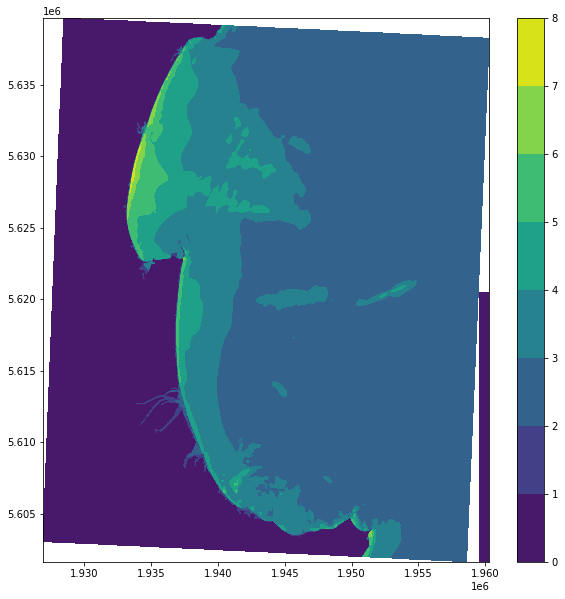

In [32]:
fig = plt.figure(figsize=(10,10))

output = plt.contourf(x,y,imarray)

plt.colorbar(output)

# Landslides

## Load Landslide data

In [33]:
# Load the data using geopandas

folder_loc = r'd_landslide/'

gdf_landslides = gpd.read_file('{}SlopeUnits.shp'.format(folder_loc))

# # convert the geopandas to pandas
df_landslides = pd.DataFrame(gdf_landslides)


## Visualise SlopeUnits file (?)

<AxesSubplot:>

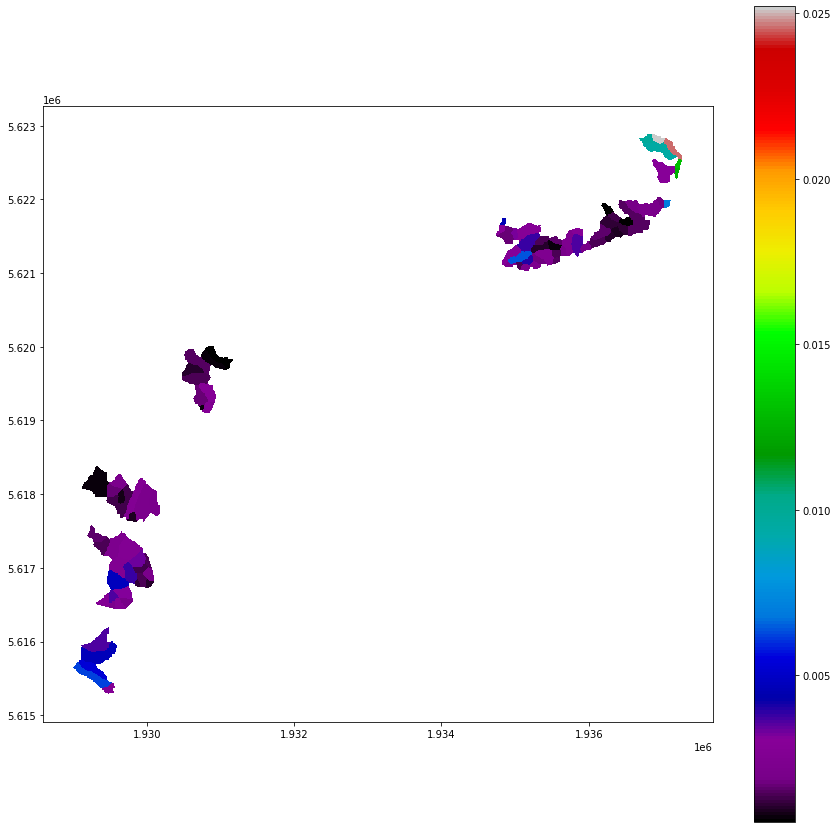

In [34]:
fig = plt.figure(figsize=(15,15))

ax1 = plt.subplot2grid((1,1),(0,0))

gdf_landslides.plot(column='LP100_max',legend=True,ax=ax1,cmap='nipy_spectral')

# ax1.set_xlim(172.8,173.2)
# ax1.set_ylim(1.3,1.68)

In [35]:

file = r'd_landslide/EIL_prob.tif'

from PIL import Image
im = Image.open(file)
imarray = np.array(im)
imarray[imarray>100000] = np.nan

df_xr = rxr.open_rasterio(file,
                                 masked=True)

x = np.array(df_xr.x)
y = np.array(df_xr.y)

df_landslides = pd.DataFrame(imarray)
df_landslides.columns = x
df_landslides.index = y
df_landslides.reset_index(drop=False,inplace=True)
df_landslides = df_landslides.melt(id_vars='index')
df_landslides.columns = ['lat','lon','landslide']
df_landslides.loc[df_landslides.landslide<0,'landslide'] = np.nan
df_landslides.dropna(inplace=True)
df_landslides.reset_index(drop=True,inplace=True)
transformer = \
    pyproj.Transformer.from_crs(pyproj.CRS("epsg:2193"),pyproj.CRS("epsg:4326"))
df_landslides[('lat,lon')] = [transformer.transform(y,x) for x,y in zip(df_landslides.lon,df_landslides.lat)]
df_landslides['lon'] = [x[1] for x in df_landslides[('lat,lon')]]
df_landslides['lat'] = [x[0] for x in df_landslides[('lat,lon')]]

In [36]:
p33 = np.percentile(df_landslides.landslide,33)
p67 = np.percentile(df_landslides.landslide,67)

In [37]:
df_landslides.loc[df_landslides.landslide<p33,'low'] = 1
df_landslides.loc[(df_landslides.landslide>p33)&(df_landslides.landslide<p67),'med'] = 1
df_landslides.loc[df_landslides.landslide>p67,'high'] = 1
df_landslides.fillna(0,inplace=True)
df_landslides

,lat,lon,landslide,"lat,lon",low,med,high
0,-39.473531,176.872023,0.000487,"(-39.47353086758621, 176.87202274926443)",1.0,0.0,0.0
1,-39.473603,176.872027,0.000489,"(-39.47360278762928, 176.87202674215783)",1.0,0.0,0.0
2,-39.473675,176.872031,0.000490,"(-39.473674707671115, 176.87203073506555)",1.0,0.0,0.0
3,-39.473747,176.872035,0.000491,"(-39.47374662771172, 176.87203472798757)",1.0,0.0,0.0
4,-39.473819,176.872039,0.000491,"(-39.473818547751094, 176.87203872092388)",1.0,0.0,0.0
...,...,...,...,...,...,...,...
192585,-39.504864,176.925943,0.000000,"(-39.50486424523151, 176.9259428990061)",1.0,0.0,0.0
192586,-39.504936,176.925947,0.000000,"(-39.504936160262766, 176.92594695192332)",1.0,0.0,0.0
192587,-39.505008,176.925951,0.000000,"(-39.50500807529278, 176.92595100485505)",1.0,0.0,0.0
192588,-39.505080,176.925955,0.000000,"(-39.505079990321555, 176.9259550578013)",1.0,0.0,0.0


## Visualise the EIL prob

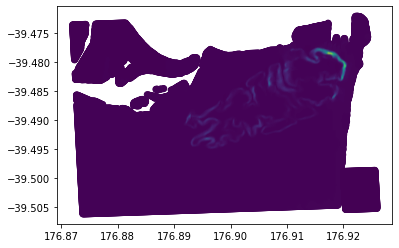

In [38]:
plt.scatter(df_landslides.lon,df_landslides.lat,c=df_landslides.landslide)

# Combining data

In [39]:
df_quake['points'] = [Point(transformer.transform(row.lat,row.lon)) for index,row in df_quake.iterrows()]
df_quake

,lat,lon,low_shaking_prob,med_shaking_prob,high_shaking_prob,Liq_Class,zero_liq,low_liq,med_liq,high_liq,points
0,-39.58472,176.85822,0.027745,0.403914,0.568341,No,1.0,0.0,0.0,0.0,POINT (-75.81516398966092 82.92646789685922)
1,-39.58472,176.86022,0.026065,0.407266,0.566669,No,1.0,0.0,0.0,0.0,POINT (-75.81516400703872 82.9264678967654)
2,-39.58472,176.86222,0.036007,0.421274,0.542719,No,1.0,0.0,0.0,0.0,POINT (-75.81516402441653 82.92646789667153)
3,-39.58472,176.86422,0.037948,0.387467,0.574585,No,1.0,0.0,0.0,0.0,POINT (-75.81516404179436 82.92646789657771)
4,-39.58472,176.86622,0.028206,0.402556,0.569238,No,1.0,0.0,0.0,0.0,POINT (-75.81516405917218 82.92646789648389)
...,...,...,...,...,...,...,...,...,...,...,...
6734,-39.40272,176.92422,0.036103,0.454159,0.509738,No,1.0,0.0,0.0,0.0,POINT (-75.81516456522206 82.92647434443209)
6735,-39.40272,176.92622,0.037729,0.435858,0.526413,No,1.0,0.0,0.0,0.0,POINT (-75.81516458259988 82.92647434433829)
6736,-39.40272,176.92822,0.036403,0.444725,0.518872,No,1.0,0.0,0.0,0.0,POINT (-75.81516459997771 82.92647434424447)
6737,-39.40272,176.93022,0.036313,0.434307,0.529380,No,1.0,0.0,0.0,0.0,POINT (-75.81516461735552 82.92647434415061)


In [40]:
# new_quake_dict = {}

# # For a single quake, loop over each area and get combined hazard at each point
# for index,row in df_quake.iterrows():
#     # transform the point to shape
#     point = row.points
    
#     point_raw = list(point.coords)[0] ## I guess that this is right?
    
#     # Add liquefaction
#     df_liq['point_in_poly'] = [x.contains(point) for x in df_liq.geometry]
#     df_liq_at_point = df_liq[df_liq['point_in_poly']==True]
#     if not df_liq_at_point.empty:
#         row['Liq_Class'] = df_liq_at_point.reset_index(drop=True).loc[0,'Liq_Class']
#     else:
#         row['Liq_Class'] = 'None'
        
#     print(index)
#     # Add to dictionary
#     new_quake_dict.update({
#         index:row
#     })

In [41]:
# df_quake_new = pd.DataFrame.from_dict(new_quake_dict,orient='index')
# df_quake_new.dropna(inplace=True)

In [42]:
# Interpolate landslides to the same dataframe as earthquake
landslide_interp = \
    sp.interpolate.griddata((df_landslides.lon,df_landslides.lat),df_landslides.landslide,
                            (df_quake.lon,df_quake.lat),method='cubic')
df_quake['landslide'] = landslide_interp

# Interpolate tsunami to the same dataframe as earthquake
tsunami_interp = \
    sp.interpolate.griddata((df_tsunami.lon,df_tsunami.lat),df_tsunami.tsu_height,
                            (df_quake.lon,df_quake.lat),method='cubic')
df_quake['tsunami'] = tsunami_interp

In [43]:
df_quake.loc[~df_quake.landslide.isna(),'landslide']=1
df_quake.loc[df_quake.landslide.isna(),'landslide']=0

### One hot encode landslide and tsunami variables

In [44]:
df_quake['tsunami_binned'] = np.round((df_quake.tsunami/(np.max(df_quake.tsunami)/3)),0)
df_quake.tsunami_binned.fillna(0,inplace=True)

In [45]:
df_tsunami_binned = pd.get_dummies(df_quake.tsunami_binned)
df_tsunami_binned.columns = ['zero_tsunami','low_tsunami','med_tsunami','high_tsunami']
df_quake = df_quake.join(df_tsunami_binned)

In [46]:
df_landslide_binned = pd.get_dummies(df_quake.landslide)
df_landslide_binned.columns = ['No_landslide','Yes_landslide']
df_quake = df_quake.join(df_landslide_binned)


In [47]:
df_quake.to_csv('example_data.csv',index=False)

In [48]:
# Save definition of liquefaction bins
tsunami_bins = [0,np.max(df_quake.tsunami)/3,2*np.max(df_quake.tsunami)/3,np.max(df_quake.tsunami)]

# Save the bin data

In [49]:
earthquake_bins_dict = {x:y for x,y in zip(['minimum','low','medium','high'],earthquake_bins)}
liquefaction_bins_dict = {x:y for x,y in zip(['zero','low','medium','high'],liquefaction_bins)}
tsunami_bins_dict = {x:y for x,y in zip(['zero','low','medium','high'],tsunami_bins)}

In [50]:
bins_dict = {
    'earthquake':earthquake_bins_dict,
    'liquefaction':liquefaction_bins_dict,
    'tsunami':tsunami_bins_dict
}

In [51]:
with open("bin_definitions.json", "w") as wf:
    json.dump(bins_dict, wf)